# EDA

In [2]:
# Import certain packages:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

import scipy.stats as ss
from scipy.stats import skew, norm
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

# Import functions from outside notebook:
from helper_functions.metrics import durbin_watson, mean_absolute_percentage_error


# Überblick der Daten

Wir lesen die CSV-Daten ein und verschaffen uns einen Überblick über die Anzahl Objekte und Features.

In [3]:
csv_data = pd.read_csv('immo_dev_data.csv')

In [4]:
csv_data['Id'].max()

42175937

In [5]:
csv_data.shape

(153627, 69)

In [6]:
csv_data.head()

,Id,AreaLiving,AreaProperty,BuiltYear,FloorNumber,ForestDensityL,ForestDensityM,ForestDensityS,GroupNameDe,HouseObject,...,gde_private_apartments,gde_social_help_quota,gde_tax,gde_workers_sector1,gde_workers_sector2,gde_workers_sector3,gde_workers_total,location_has_street,location_is_complete,PurchasePrice
0,7135329,140.0,501.0,2016,NaN,0.418964,0.555985,0.730714,Haus,True,...,1358.0,3.660512,8.73,17.0,162.0,358.0,537.0,0,0,745000.0
1,7170979,143.0,277.0,2004,NaN,0.033259,0.074061,0.076468,Haus,True,...,3476.0,3.634717,6.13,0.0,2250.0,2787.0,5041.0,1,1,780000.0
2,7172246,160.0,712.0,1945,NaN,0.000000,0.000000,0.000000,Haus,True,...,2806.0,2.512344,9.79,167.0,1694.0,1138.0,2999.0,0,0,570000.0
3,7172252,351.0,496.0,2016,NaN,0.037575,0.000000,0.000000,Haus,True,...,131.0,1.734104,9.15,12.0,10.0,17.0,39.0,0,0,920000.0
4,7172733,400.0,1800.0,1975,NaN,0.095162,0.097193,0.153314,Haus,True,...,1181.0,1.056052,2.97,0.0,27.0,701.0,732.0,0,0,3950000.0


Das CSV beinhaltet 153'627 Spalten (Objekte) und 69 Kolonnen (Features). Mittels `head()` betrachten wir uns die ersten 5 Einträge. Da die Standardeinstellung des Notebooks die 69 Features mittig schneidet, geben wir die alle Features separat aus.

In [7]:
csv_data.columns

Index(['Id', 'AreaLiving', 'AreaProperty', 'BuiltYear', 'FloorNumber',
       'ForestDensityL', 'ForestDensityM', 'ForestDensityS', 'GroupNameDe',
       'HouseObject', 'LastUpdate', 'Latitude', 'Locality', 'Longitude',
       'Name', 'NoisePollutionRailwayL', 'NoisePollutionRailwayM',
       'NoisePollutionRailwayS', 'NoisePollutionRoadL', 'NoisePollutionRoadM',
       'NoisePollutionRoadS', 'PopulationDensityL', 'PopulationDensityM',
       'PopulationDensityS', 'RealEstateTypeId', 'Renovationyear',
       'RiversAndLakesL', 'RiversAndLakesM', 'RiversAndLakesS', 'Rooms',
       'SourceId', 'StateShort', 'StreetAndNr', 'TravelTimeMiv',
       'WorkplaceDensityL', 'WorkplaceDensityM', 'WorkplaceDensityS', 'Zip',
       'distanceToTrainStation', 'gde_area_agriculture_percentage',
       'gde_area_forest_percentage', 'gde_area_nonproductive_percentage',
       'gde_area_settlement_percentage', 'gde_average_house_hold',
       'gde_empty_apartments', 'gde_foreigners_percentage',
       'g

# Fehlende Werte

Wir werfen einen Blick auf die `NAs`, also die fehlenden Werte. Folgende Tabelle listet diese je Feature auf.

In [8]:
def get_na_df(df):
    '''
    Returns a dataframe with an overview of missing values.
    '''
    name = []
    value = []

    for i in df.columns:
        if df[i].isnull().sum() > 1:
            name.append(i)
            value.append([df[i].isnull().sum()])
    
    return pd.DataFrame.from_dict(dict((zip(name, value)))).melt(var_name = 'feature', value_name = 'number_na')

In [9]:
get_na_df(csv_data)

,feature,number_na
0,FloorNumber,87695
1,Renovationyear,138326
2,StreetAndNr,46435
3,TravelTimeMiv,2
4,gde_area_agriculture_percentage,2
5,gde_area_forest_percentage,2
6,gde_area_nonproductive_percentage,2
7,gde_area_settlement_percentage,2
8,gde_average_house_hold,2
9,gde_empty_apartments,2


Wir sehen, dass von den insgesamt 69 Features Werte bei 30 Features fehlen. Bei mehr als der Hälfte dieser, fehlen sehr wenige, sodass diese vernachlässigbar sind. Diese werden für die weitere Analyse gelöscht.

Bei weiteren Featuers fehlt hingegen ein beachtlicher Teil an entsprechenden Angaben, beispielsweise:
- Renovationyear: 138'326
- FloorNumber: 87'695

Speziell beim Renovationsjahr dürfen die fehlenden Werte aber nicht als nicht vorhandene Information gedeutet werden. Vielmehr wurde das Haus womöglich schlicht (noch?) nicht renoviert.

Eine ähnliche Aussage kann auch für die `FloorNumber` gemacht werden: ist das Objekt ein ganzes Haus, so scheint die Angabe einer Etage nicht nötig resp. sinnvoll.

# Grobüberblick von numerischen Attributen

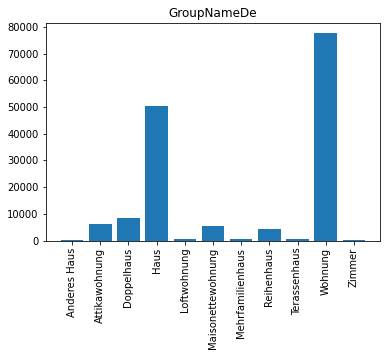

count      153627
unique         11
top       Wohnung
freq        77499
Name: GroupNameDe, dtype: object

In [10]:
feature = csv_data.columns[8]

plt.bar(csv_data[feature].groupby(csv_data[feature]).count().to_dict().keys(), csv_data[feature].groupby(csv_data[feature]).count().to_dict().values())
plt.xticks(rotation = 90)
plt.title(feature)
plt.show()
csv_data[feature].describe()

/Users/ericwinter/opt/miniconda3/envs/py38/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:201: UserWarning: When passing multiple axes, layout keyword is ignored
  warnings.warn(
/Users/ericwinter/opt/miniconda3/envs/py38/lib/python3.8/site-packages/pandas/plotting/_matplotlib/boxplot.py:385: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  ax = boxplot(


array([<AxesSubplot:title={'center':'AreaLiving'}>,
       <AxesSubplot:title={'center':'PurchasePrice'}>,
       <AxesSubplot:title={'center':'Rooms'}>,
       <AxesSubplot:title={'center':'gde_foreigners_percentage'}>,
       <AxesSubplot:title={'center':'gde_tax'}>,
       <AxesSubplot:title={'center':'gde_pop_per_km2'}>,
       <AxesSubplot:title={'center':'gde_average_house_hold'}>,
       <AxesSubplot:title={'center':'gde_politics_fdp'}>], dtype=object)

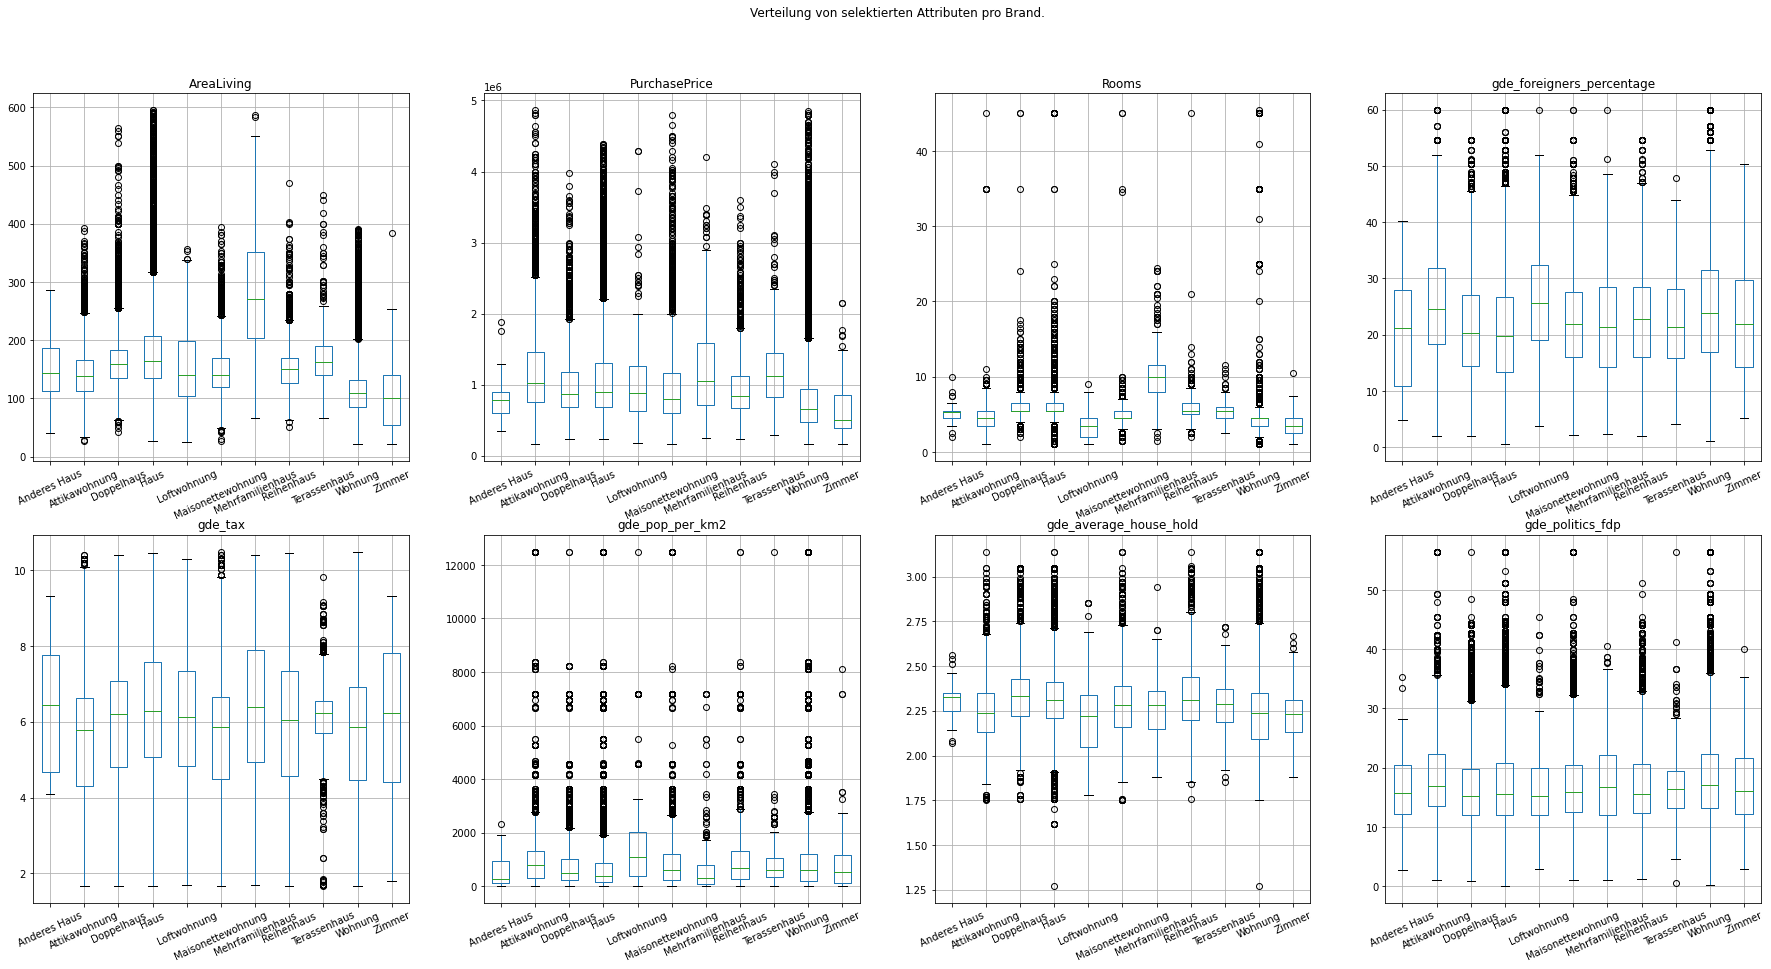

In [11]:
values_to_analyse = ['AreaLiving', 'PurchasePrice', 'Rooms', 'gde_foreigners_percentage', 'gde_tax', 'gde_pop_per_km2', 'gde_average_house_hold', 'gde_politics_fdp']
fig, ax_new = plt.subplots(2,4, sharey=False, figsize = (30, 15))
boxplot = csv_data.boxplot(column = values_to_analyse, ax=ax_new,layout=(2,4), by='GroupNameDe', rot=25)
fig.suptitle('Verteilung von selektierten Attributen pro Brand.')
for ax in boxplot:
    ax.set_xlabel('')
boxplot

Im obigen Plot, der einige Features dem `GroupNameDe`, also dem "Haustyp", gegenüberstellt, lässt sich ein Trend erkennen, der aber im Allgemeinen ähnlich ist – will heissen: die Boxplots verlaufen je Häusertyp (grob vereinfacht) ähnlich; und dort, wo sie abweichen, erscheinen sie plausibel. Z. B. scheint klar, dass ein Mehrfamilienhaus mehr Räume hat, als eine Loftwohnung.

Im folgenden Plot untersuchen wir nun, wie die Lage einer Immobilie Einfluss auf ihren Preis hat. Wir nehmen dazu den Durchschnittspreis pro `GroupNameDe`.

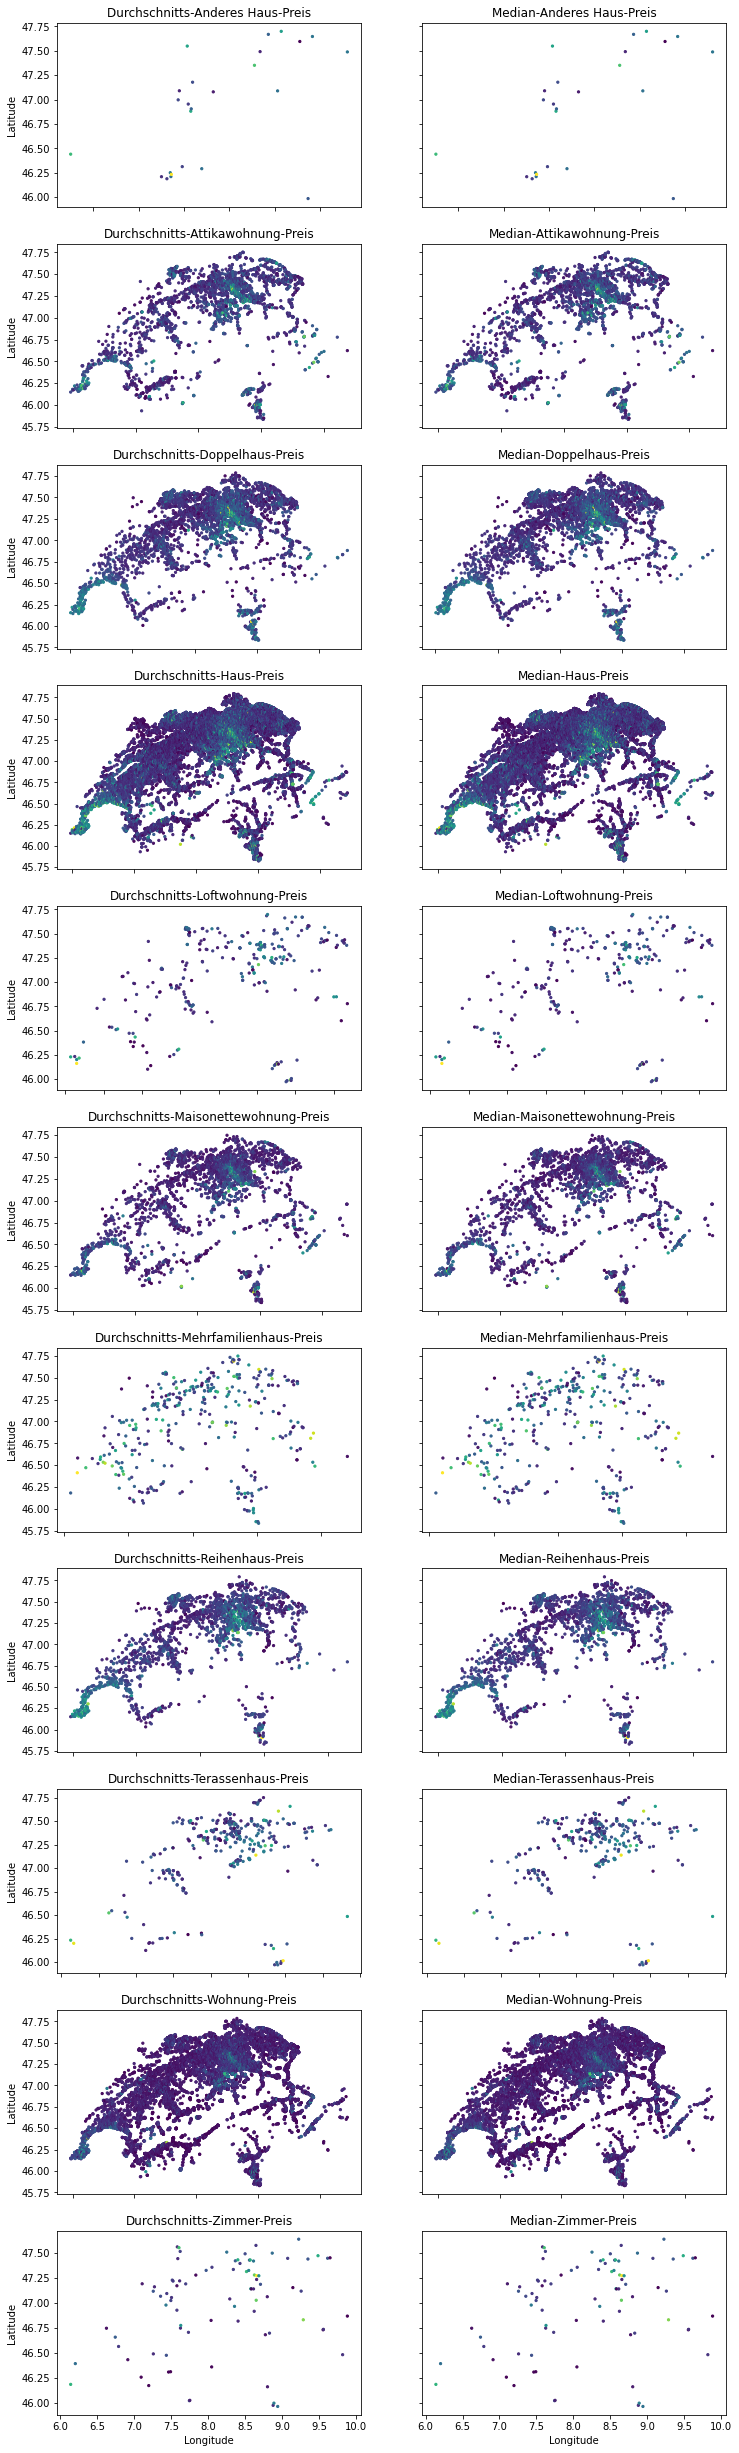

In [12]:
csv_data_long_lat_rounded = csv_data.copy()
csv_data_long_lat_rounded['Longitude'] = np.round(csv_data_long_lat_rounded['Longitude'],3)
csv_data_long_lat_rounded['Latitude'] = np.round(csv_data_long_lat_rounded['Latitude'],3)

rows = len(np.unique(csv_data_long_lat_rounded['GroupNameDe']))
fig, axs = plt.subplots(rows, 2, figsize = (12, 4*rows))
for i, col in enumerate(np.unique(csv_data_long_lat_rounded['GroupNameDe'])):
    df_ = csv_data_long_lat_rounded[csv_data_long_lat_rounded['GroupNameDe']==col]
    df_mean_ = df_.groupby(by=['GroupNameDe', 'Longitude', 'Latitude']).mean().reset_index()
    df_median_ = df_.groupby(by=['GroupNameDe', 'Longitude', 'Latitude']).median().reset_index()
    axs[i, 0].scatter(df_mean_['Longitude'], df_mean_['Latitude'], c = df_mean_['PurchasePrice'], s = 5),
    axs[i, 0].set_title('Durchschnitts-{}-Preis'.format(col))
    axs[i, 1].scatter(df_median_['Longitude'], df_median_['Latitude'], c = df_median_['PurchasePrice'], s = 5)
    axs[i, 1].set_title('Median-{}-Preis'.format(col))

for ax in axs.flat:
    ax.set(xlabel='Longitude', ylabel='Latitude')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

Deutlich lässt sich erkennen, dass die Lage einer Immobilie Einfluss auf ihren Preis hat. Die – für ihre hohen Preise bekannten – Regionen am/um den Zürichsee, Genfersee, Luganersee und die Umgebung um St. Moritz "leuchten" auf. Die hellen Farben symbolisieren einen hohen, die dunklen Farben einen tiefen Immobilienpreis.

Bei der Prediction wird der Standort eine wichtige Rolle einnehmen; entweder durch die Longitude und Latitude oder durch die Postleitzahl.

Interessant ist auch die Verteilung aller numerischen Werte auf der Symlog-Skala. Dies ist eine Skala, welche – ausser man ist nahe bei 0 – der Log-Skala entspricht. Um 0 herum ist diese linear, womit die Explosion des Logs auf "+/- unendlich" verhindert wird.

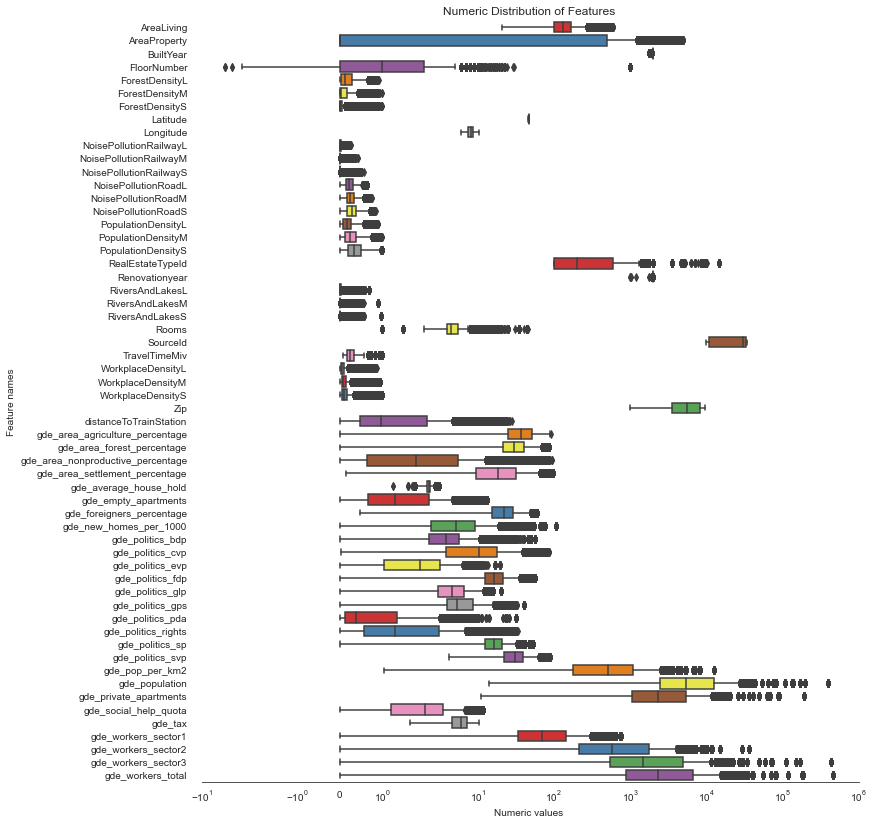

In [13]:
# Create box plots for all numeric features
# Code taken from https://www.kaggle.com/lavanyashukla01/how-i-made-top-0-3-on-a-kaggle-competition and adapted to our needs.
sns.set_style("white")
f, ax = plt.subplots(figsize=(12, 14))
ax.set_xscale("symlog")
ax = sns.boxplot(data=csv_data.select_dtypes('number').drop(columns=['Id', 'PurchasePrice', 'location_has_street', 'location_is_complete']), orient="h", palette="Set1")
ax.xaxis.grid(False)
ax.set(ylabel="Feature names")
ax.set(xlabel="Numeric values")
ax.set(title="Numeric Distribution of Features")
sns.despine(trim=True, left=True)

Viele Features sind schief-verteilt. Mit Hilfe einer [Box Cox Transformation](https://towardsdatascience.com/box-cox-transformation-explained-51d745e34203) lässt sich diese Eigenschaft abschwächen. Somit könnte unser Modell stabiler werden.

Die "Skewness" ist das Verhältnis vom Mittelwert zur Standardabweichung: desto höher, desto "skewter".

In [14]:
# Find skewed numerical features
# Code taken from https://www.kaggle.com/lavanyashukla01/how-i-made-top-0-3-on-a-kaggle-competition and adapted to our needs.
skew_features = csv_data.select_dtypes('number').drop(columns=['Id', 'PurchasePrice', 'location_has_street', 'location_is_complete']).apply(lambda x: skew(x)).sort_values(ascending=False)

high_skew = skew_features[skew_features > 0.5]
skew_index = high_skew.index

print("There are {} numerical features with Skew > 0.5 :".format(high_skew.shape[0]))
skewness = pd.DataFrame({'Skew' :high_skew})
skew_features.head(20)



There are 20 numerical features with Skew > 0.5 :


RiversAndLakesS           9.870534
RealEstateTypeId          6.261766
Rooms                     5.363506
NoisePollutionRailwayS    4.905221
RiversAndLakesM           4.858933
RiversAndLakesL           3.624726
NoisePollutionRailwayM    3.609659
WorkplaceDensityL         3.284066
distanceToTrainStation    3.208185
AreaProperty              3.008660
WorkplaceDensityM         2.661331
NoisePollutionRailwayL    2.628042
ForestDensityS            2.562313
WorkplaceDensityS         2.399048
ForestDensityM            1.647688
AreaLiving                1.607749
ForestDensityL            1.007906
PopulationDensityL        1.002755
PopulationDensityM        0.647705
NoisePollutionRoadL       0.540166
dtype: float64

# Wie korrelieren die numerischen Werte mit dem Preis?

Wir berechnen die Korrelation der einzelnen Features mit dem Verkaufspreis mit Hilfe des Spearman-Koeffizienten. Dieser betrachtet die Kovarianz mit den Standardabweichungen von den zu vergleichenden Attributen und vergleicht deren Ränge. Die Ränge der Werte sind die nach der Reihenfolge der nach der Grösse  seiner 

Der Spearman-Koeffizient wird auch als Rangkorrelationskoeffizient genannt, weil er die Korrelation nicht zwischen den Datenpunkten selbst, sondern zwischen ihren Rängen berechnet.

In [15]:
csv_data_corr = csv_data.drop(columns = ['Id', 'Zip', 'Longitude', 'Latitude']).corr(method='spearman')
csv_data_corr_filtered = csv_data_corr[np.abs(csv_data_corr)>0.1]['PurchasePrice']
csv_data_corr_filtered.dropna()

AreaLiving                           0.677319
AreaProperty                         0.302468
BuiltYear                            0.156482
HouseObject                          0.260701
PopulationDensityL                   0.118138
RealEstateTypeId                     0.247618
Rooms                                0.508444
TravelTimeMiv                       -0.301922
WorkplaceDensityL                    0.131320
WorkplaceDensityM                    0.101484
gde_area_nonproductive_percentage   -0.135720
gde_area_settlement_percentage       0.219687
gde_empty_apartments                -0.186640
gde_foreigners_percentage            0.132322
gde_politics_bdp                    -0.203626
gde_politics_fdp                     0.212381
gde_politics_gps                     0.144317
gde_politics_svp                    -0.115015
gde_pop_per_km2                      0.231552
gde_population                       0.150899
gde_private_apartments               0.146832
gde_tax                           

Korrelationen können nur zwischen Zahlen und nicht zwischen Zeichen (Strings) berechnet werden.

Bei der Postleitzahl darf nicht vorschnell ein Zusammenhang zwischen ihrer Höhe und dem Verkaufspreis konstruiert werden. Die Höhe einer Postleitzahl hat keine besondere Bedeutung, vielmehr hat sie kategorialen Charakter. Da die Postleitzahl viele Werte annehmen kann, müssen wir diese Werte one-hot-encoden. Das führte aber zu (zu) vielen "Einzelkolonnen", weswegen wir hier vereinfachen: wir kürzen die Postleitzahl auf 2 oder 3 Stellen.

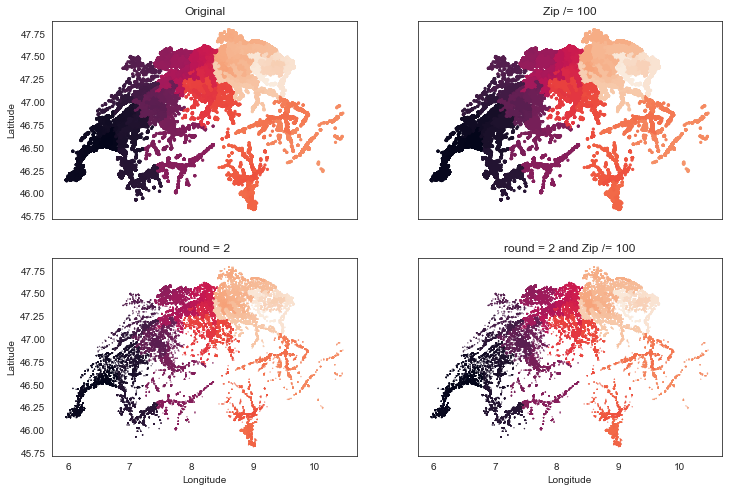

In [16]:
fig, axs = plt.subplots(2, 2, figsize = (12, 8))
axs[0, 0].scatter(csv_data['Longitude'], csv_data['Latitude'], c = csv_data['Zip'], s = 5)
axs[0, 0].set_title('Original')
axs[0, 1].scatter(csv_data['Longitude'], csv_data['Latitude'], c = (csv_data['Zip'] / 100).astype('int64'), s = 5)
axs[0, 1].set_title('Zip /= 100')
axs[1, 0].scatter(csv_data['Longitude'].round(decimals = 2), csv_data['Latitude'].round(decimals = 2), c = csv_data['Zip'], s = 0.1)
axs[1, 0].set_title('round = 2')
axs[1, 1].scatter(csv_data['Longitude'].round(decimals = 2), csv_data['Latitude'].round(decimals = 2), c = (csv_data['Zip'] / 100).astype('int64'), s = 0.1)
axs[1, 1].set_title('round = 2 and Zip /= 100')

for ax in axs.flat:
    ax.set(xlabel='Longitude', ylabel='Latitude')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

Mit den Postleitzahlen können die einzelnen "Orte" sehr genau lokalisiert resp. zugeordnet werden. Auch beim Kürzen und Runden der Postleitzahl ist die Lokalisation nach wie vor möglich. Wir beschränken uns somit auf die ersten beiden Ziffern der Postleitzahl und verzichten auf die exakte Position mittels Longitude und Latitude.

# Verteilung des Kaufpreises

/Users/ericwinter/opt/miniconda3/envs/py38/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)



 mu = 13.59 and sigma = 0.55



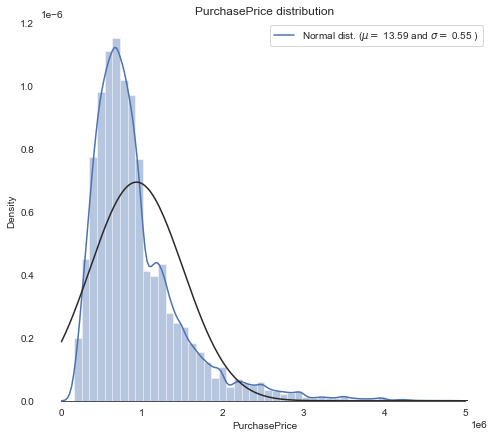

In [17]:
sns.set_style("white")
sns.set_color_codes(palette='deep')
f, ax = plt.subplots(figsize=(8, 7))
#Check the new distribution 
sns.distplot(csv_data['PurchasePrice'] , fit=norm, color="b")

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(np.log(csv_data['PurchasePrice']))
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
ax.xaxis.grid(False)
ax.set(ylabel="Density")
ax.set(xlabel="PurchasePrice")
ax.set(title="PurchasePrice distribution")
sns.despine(trim=True, left=True)

plt.show()

Der Verkaufspreis ist nicht normalverteilt. Wir nehmen somit den `log` und stellen seine Verteilung erneut dar.

/Users/ericwinter/opt/miniconda3/envs/py38/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)



 mu = 13.59 and sigma = 0.55



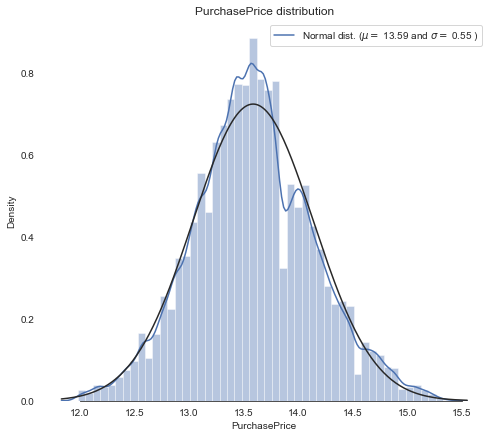

In [18]:
sns.set_style("white")
sns.set_color_codes(palette='deep')
f, ax = plt.subplots(figsize=(8, 7))
#Check the new distribution 
sns.distplot(np.log(csv_data['PurchasePrice']) , fit=norm, color="b")

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(np.log(csv_data['PurchasePrice']))
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
ax.xaxis.grid(False)
ax.set(ylabel="Density")
ax.set(xlabel="PurchasePrice")
ax.set(title="PurchasePrice distribution")
sns.despine(trim=True, left=True)

plt.show()